# Desenvolvimento de um Classificador de Bayes com KDE

In [1]:
# Imports:
from numpy import pi
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC as svm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import math

In [2]:
# Bynary Bayes Classifier with KDE
class bayes_classifier:

    # To initialize the parameters from the Bayes algorithm:
    def __init__(self):
        self.p_ci = None
        self.X_train = None
        self.y_train = None
    
    # Gaussian function
    def kgaussian(self, u, h):
        K = 1/(math.sqrt(2*np.pi)*h) * math.exp(-0.5*(u**2))
        return K 

    # My KDE Implementation
    def my_kde(self, x, indexes_to_train, h):
        N_train = self.X_train.shape[0]
        n_train = self.X_train.shape[1]
        px = np.zeros(N_train)
        K_total = 0
        for i in indexes_to_train:
            u = math.sqrt(sum((x - self.X_train[i,:])**2))/h
            K_total += self.kgaussian(u, h) 
        return K_total/N_train
        
    # Training the model
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n = np.unique(y).shape[0]
        self.p_ci =  np.zeros(n)
        for i in range(0,n):
            n_elements = np.count_nonzero(self.y_train==np.unique(self.y_train)[i])
            total_elements = self.y_train.shape[0]
            self.p_ci[i] = n_elements/total_elements  
    
    # Function to classify data 
    def predict(self, X, h):
        # Calculate PDFs:
        n = np.unique(self.y_train).shape[0]
        pdf = np.zeros(n)
        y = np.zeros(X.shape[0]) 
        for j in range(0, X.shape[0]):
            for i in range(0,n):
                indexes = np.where(self.y_train==np.unique(self.y_train)[i])[0]
                pdf[i] = self.my_kde(X[j,0:2], indexes, h)
            K = (pdf[1] * self.p_ci[1])/(pdf[0] * self.p_ci[0])
            if K >= 1:
                y[j] = 1
            else:
                y[j] = 0
        return y

# Base de Dados

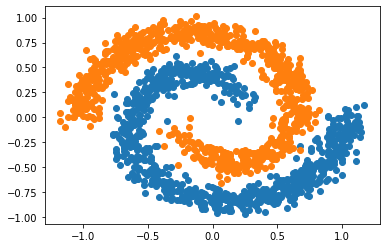

In [3]:
# Generating spiral data:
# (Code from: https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5)
N = 800
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)
r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = (data_a + np.random.randn(N,2))/15
r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = (data_b + np.random.randn(N,2))/15
res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)
res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)
np.savetxt("spiral_data.csv", res, delimiter=",", header="x,y,label", comments="", fmt='%.5f')
plt.scatter(x_a[:,0],x_a[:,1])
plt.scatter(x_b[:,0],x_b[:,1])
plt.show()

# 10-fold Cross Validation

In [4]:
k_fold = KFold(n_splits=10)
acc = np.zeros(10)
i = 0
for train_indices, test_indices in k_fold.split(res):
    clf = bayes_classifier()
    clf.fit(res[train_indices, 0:2], res[train_indices, 2])
    y_pred = clf.predict(res[test_indices, 0:2], 0.1)
    acc[i] = accuracy_score(res[test_indices, 2], y_pred)
    print("Acurácia para o fold " + str(i+1) + ": " + str(acc[i]))
    i +=1
    
print("\nAcurácia Média: " + str(acc.mean()) + "+/-" + str(acc.std()))   

Acurácia para o fold 1: 1.0
Acurácia para o fold 2: 0.99375
Acurácia para o fold 3: 1.0
Acurácia para o fold 4: 0.99375
Acurácia para o fold 5: 1.0
Acurácia para o fold 6: 0.9875
Acurácia para o fold 7: 0.99375
Acurácia para o fold 8: 1.0
Acurácia para o fold 9: 0.9875
Acurácia para o fold 10: 1.0

Acurácia Média: 0.9956250000000001+/-0.004881406047441642


# Visualização da Superfície de Separação

Text(0.5, 0.92, 'Superfície de separação.')

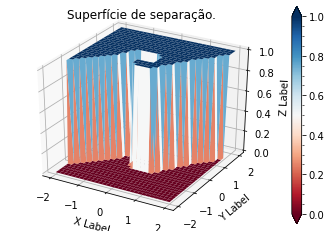

In [5]:
def plot_surface(model, plot_support=True, x_min_max=(-2,2), y_min_max=(-2,2),  vectors_color="none"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # create grid to evaluate model
    x = np.linspace(x_min_max[0], x_min_max[1], 30)
    y = np.linspace(y_min_max[0], y_min_max[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    Z = clf.predict(xy, 0.2).reshape(X.shape)
    # plot decision boundary and margins
    figure= ax.plot_surface(X, Y, Z,rstride=1, cstride=1, cmap='RdBu',edgecolor='none')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    cbar = fig.colorbar(figure, ax=ax, extend='both')
    cbar.minorticks_on()

plot_surface(model = clf);
plt.title("Superfície de separação.")

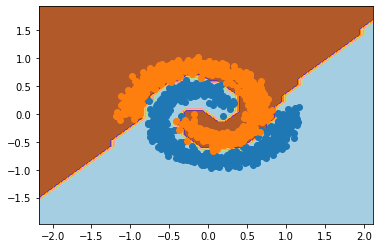

In [6]:
def plot_decision_border(X, y, clf):
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = clf.predict(grid, 0.1)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    # show the plot
    plt.show()

    
plot_decision_border(res[:,0:2], res[:,2], clf)

# Superfície de Densidade de Probabilidade 

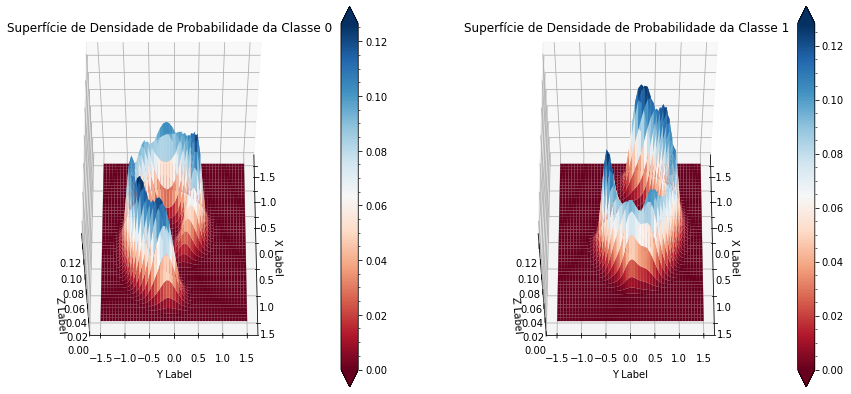

In [38]:
def plot_probability_density_surface(model, plot_support=True, x_min_max=(-1.5,1.5), y_min_max=(-1.5,1.5),  vectors_color="none"):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(121, projection='3d')
    # create grid to evaluate model
    x = np.linspace(x_min_max[0], x_min_max[1], 50)
    y = np.linspace(y_min_max[0], y_min_max[1], 50)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    Z = np.zeros(xy.shape[0])
    indexes = np.where(res[:,2]==np.unique(res[:,2])[0])[0]
    for i in range(xy.shape[0]):
        Z[i] = model.my_kde(xy[i,:], indexes, 0.1)
    Z=Z.reshape(X.shape)
    # plot decision boundary and margins
    figure= ax.plot_surface(X, Y, Z, cmap='RdBu',edgecolor='none')
    plt.title("Superfície de Densidade de Probabilidade da Classe 0")
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    #ax.axis('off')
    ax.view_init(60,0)
    cbar = fig.colorbar(figure, ax=ax, extend='both')
    cbar.minorticks_on()
    
    ax2 = fig.add_subplot(122, projection='3d')
    indexes = np.where(res[:,2]==np.unique(res[:,2])[1])[0]
    Z = np.zeros(xy.shape[0])
    for i in range(xy.shape[0]):
        Z[i] = model.my_kde(xy[i,:], indexes, 0.1)
    Z=Z.reshape(X.shape)
    # plot decision boundary and margins
    figure= ax2.plot_surface(X, Y, Z, cmap='RdBu',edgecolor='none')
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')
    ax2.set_zlabel('Z Label')
    plt.title("Superfície de Densidade de Probabilidade da Classe 1")
    #ax.axis('off')
    ax2.view_init(60,0)
    cbar = fig.colorbar(figure, ax=ax2, extend='both')
    cbar.minorticks_on()
    
clf = bayes_classifier()
clf.fit(res[:, 0:2], res[:, 2])    
plot_probability_density_surface(model = clf);


# Conclusão

Neste exercício foi possível implementar e testar o funcionamento de um classificador de Bayes utilizando a estimação de densidades a partir do método KDE. Pôde-se perceber sua eficácia em resolver problemas como o proposto, visto que na maioria dos testes deste exercício obteve-se uma acurácia acima de 95% e utilizando h=0.1 para o KDE obteve-se uma acurácia média próxima de 100%. O parâmetro 'h' foi selecionado através da avaliação da acurácia para  diversos testes com diferentes valores de 'h'. 

Além disso, através das superfícies de separação mostradas foi possível visualizar a eficiência do modelo em classificar as amostras de ambas as classes do problema.  